In [1]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate
%pip install pyxirr
%pip install openpyxl
%pip install folium
%pip install html2image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pyxirr in c:\users\crcam\appdata\local\programs\python\python313\lib\site-packages (0.10.6)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#local models
from typing import Dict
from models.econometrics import Cost, Currency
from models.components import Component
from models.econometrics import Cost
from models.geometry import Orientation
from models.photovoltaic import Photovoltaic


#init project
from models.components import Tech
from models.consumption import Energetic
from models.inventory import Building, Project
import pandas as pd

In [3]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

## Address and general info🌎

## Energy Consumptions🔌

In [4]:
#cspell:disable


project:Project = Project(
    title='Sistema PV MHNV OnGrid-Mixto',
    building = Building(
        geolocation=(-33.047016, -71.621509),
        name='Edificio Carlos Porter MHNV',
        address='Calle Condell 1546',
        city='Valparaíso'),
    technology= [Tech.PHOTOVOLTAIC],
    consumption= {
        'description':'main',
        'energetic':Energetic.ELI,
        'cost_increment':8/100,
        'consumption':[
            (1051,"01-02-2023",97361),
            (1123,"02-03-2023",104031),
            (1157,"03-04-2023",107181),
            (1220,"04-05-2023",137911),
            (1299,"01-06-2023",146841),
            (1549,"04-07-2023",175101),
            (1353,"02-08-2023",152946),
            (1420,"01-09-2023",160519),
            (1283,"03-10-2023",145033),
            (1275,"03-11-2023",144128),
            (1346,"03-12-2023",152155),
            (1438,"03-01-2024",162554),

            ],
        }
    )

getting weather data...
api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-33.047016&longitude=-71.621509&start=20230101&end=20231231&format=JSON
getting currencies data...
set $1 Peso Chileno... on USD$0.00 
set $1 UF............. on USD$39.21 
set $1 UTM............ on USD$68.50 
set $1 Euro........... on USD$1.05 
set $1 Pound.......... on USD$1.27 
set $1 Real........... on USD$0.17 
adding consumptions data...


# Integration 

## Machine Components 🎡

In [5]:
#cspell: disable
#repository of reusable components
from libs.repository import repo
#clean previous load
project.components = {}

from IPython.display import clear_output

from models.energy_storage import Battery
from models.photovoltaic import Length, PvTechnicalSheet
clear_output(wait=True)

# assembly projects components
project.add_component(
    'generación',
    Photovoltaic(project.weather,'Modular 01-PV',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel PV 650W 48V',
                quantity=9,
                cost=None,
                orientation=Orientation(35,28),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM),efficiency=0.06),
                ),
    Photovoltaic(project.weather,'Modular 02-PV',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel 650W 48V',
                quantity=11,
                cost=None,
                orientation=Orientation(20,28),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM),efficiency=0.06),
                ),
    Photovoltaic(project.weather,'Modular 03-PV',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel 650W 48V',
                quantity=4,
                cost=None,
                orientation=Orientation(10,28),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM),efficiency=0.06),
                ),
    generator=True
    )

project.add_component(
    'auxiliar',
    repo['inverter']['Deye 12kW'],
    # Component('Controlador de Carga',
    #             model='Enertik 80A 12/24V',
    #             specification='1000W to 2000 24V output',
    #             cost_per_unit=Cost(101600,Currency.CLP)),
    Component('medidor bidireccional',
                model='Elster AS1440',
                specification='Trifasico',
                cost_per_unit=Cost(306990,Currency.CLP)),
    # Battery('almacenamiento',
    #             model='MP GEL12-250',
    #             reference='https://www.tiendatecnored.cl/bateria-gel-ciclo-profundo-12v-250ah.html',
    #             cost_per_unit=Cost(305990,Currency.CLP),
    #             volt=12,
    #             charge=250,
    #             demand=project.building.consumption_forecast(['main'])['energy'].to_list(),
    #             hours_autonomy=4,
    #             use_regime='8/5',
                # )
    )

#gen number of panels
pv_quantity = sum(list(map(lambda it:it.quantity,project.components['generación'])))

project.add_component(
    'obras',
    Component(description='instalación eléctrica',
            specification='H/P eléctrico',
            cost_per_unit=Cost(0.75,currency=Currency.UF),
            quantity=pv_quantity*5,
            ),
    Component(description='estructura de soporte',
            specification='elementos fijación',
            cost_per_unit=Cost((4*800+11400/4+4*700+4000+500)),
            quantity=pv_quantity*4
            )
)


inside cost pv :  245990.0 Currency.CLP
inside cost pv :  245990.0 Currency.CLP
inside cost pv :  245990.0 Currency.CLP


# Write Document 📒


In [6]:
import os
PATH = 'build/'+f'r_{project.building.city.lower()[:3]}_{project.building.name}/'

if not os.path.exists(PATH):
    #create
    os.makedirs(PATH)

### Saving results on EXCEL ❎

In [7]:
from models.plotter import toTable
toTable(project,PATH)

### Generate Context->Doc📄✍️

In [8]:
from docxtpl import DocxTemplate # type: ignore
#init doc
#assembly proxy object 
memory_report = DocxTemplate("templates/memory_template.docx")
bidding_report = DocxTemplate("templates/bidding_template.docx")

## Write params and tables

In [9]:
#loading context
#cspell: disable
memory_report.render(project.context(template=memory_report))
bidding_report.render(project.context(template=bidding_report))


## Insert Plots 📊

In [10]:
bucket_df = project.bucket_list(Currency.CLP)['bucket']
#cspell: disable
bucket_df[['description','details','quantity','cost_after_tax']]\
    .rename(columns={
                        'description':'descripción',
                        'details':'técnico',
                        'quantity':'cantidad',
                        'cost_after_tax':'costo bruto'
                    }).to_markdown(index=False,floatfmt=',.0f')

'| descripción                | técnico                 |   cantidad |   costo bruto |\n|:---------------------------|:------------------------|-----------:|--------------:|\n| Modular 01-PV              | Solar Panel PV 650W 48V |          9 |     2,634,553 |\n| Modular 02-PV              | Solar Panel 650W 48V    |         11 |     3,220,009 |\n| Modular 03-PV              | Solar Panel 650W 48V    |          4 |     1,170,912 |\n| Inversor Híbrido Trifásico | Híbrido 12kW Trifásico  |          1 |     3,273,343 |\n| medidor bidireccional      | Trifasico               |          1 |       365,318 |\n| instalación eléctrica      | H/P eléctrico           |        120 |     3,432,060 |\n| estructura de soporte      | elementos fijación      |         96 |     1,525,104 |'

c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:133: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = module.fillna(0).pivot_table(
c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:133: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = module.fillna(0).pivot_table(
c:\Users\crcam\Dev\pv-report-modeler\models\plotter.py:133: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `p

plot_done


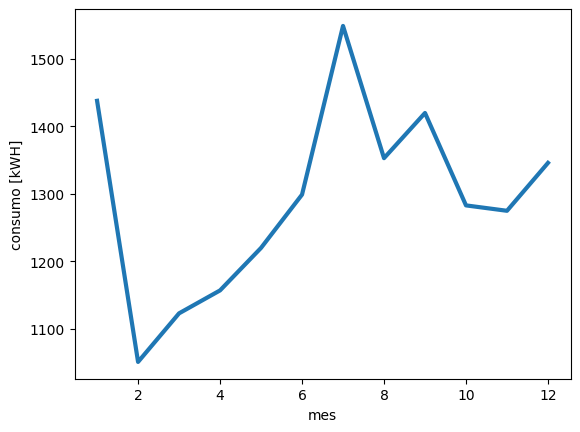

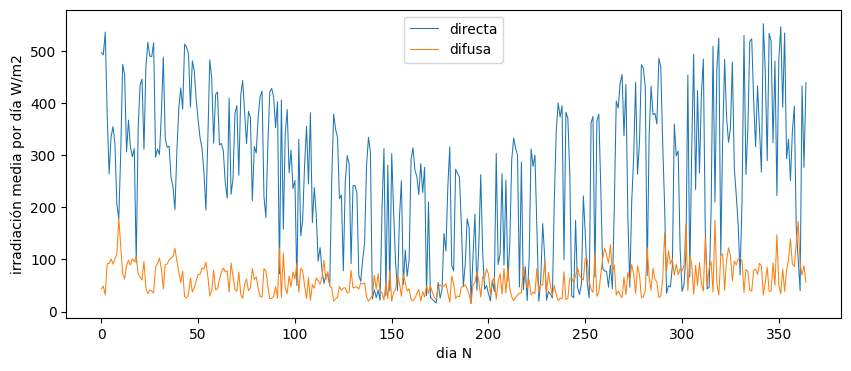

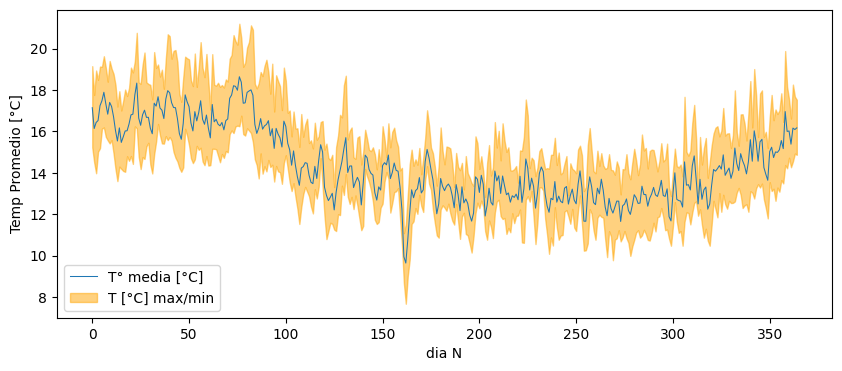

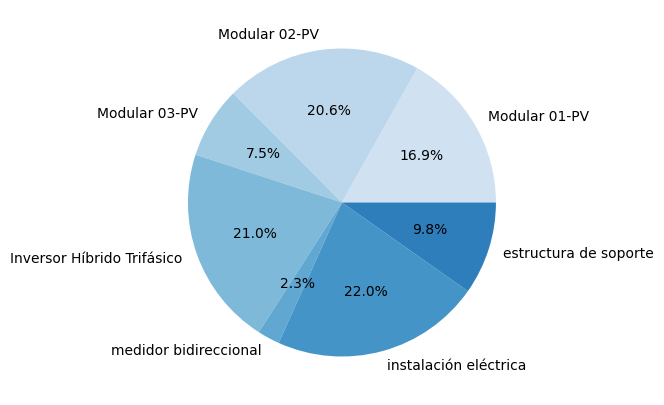

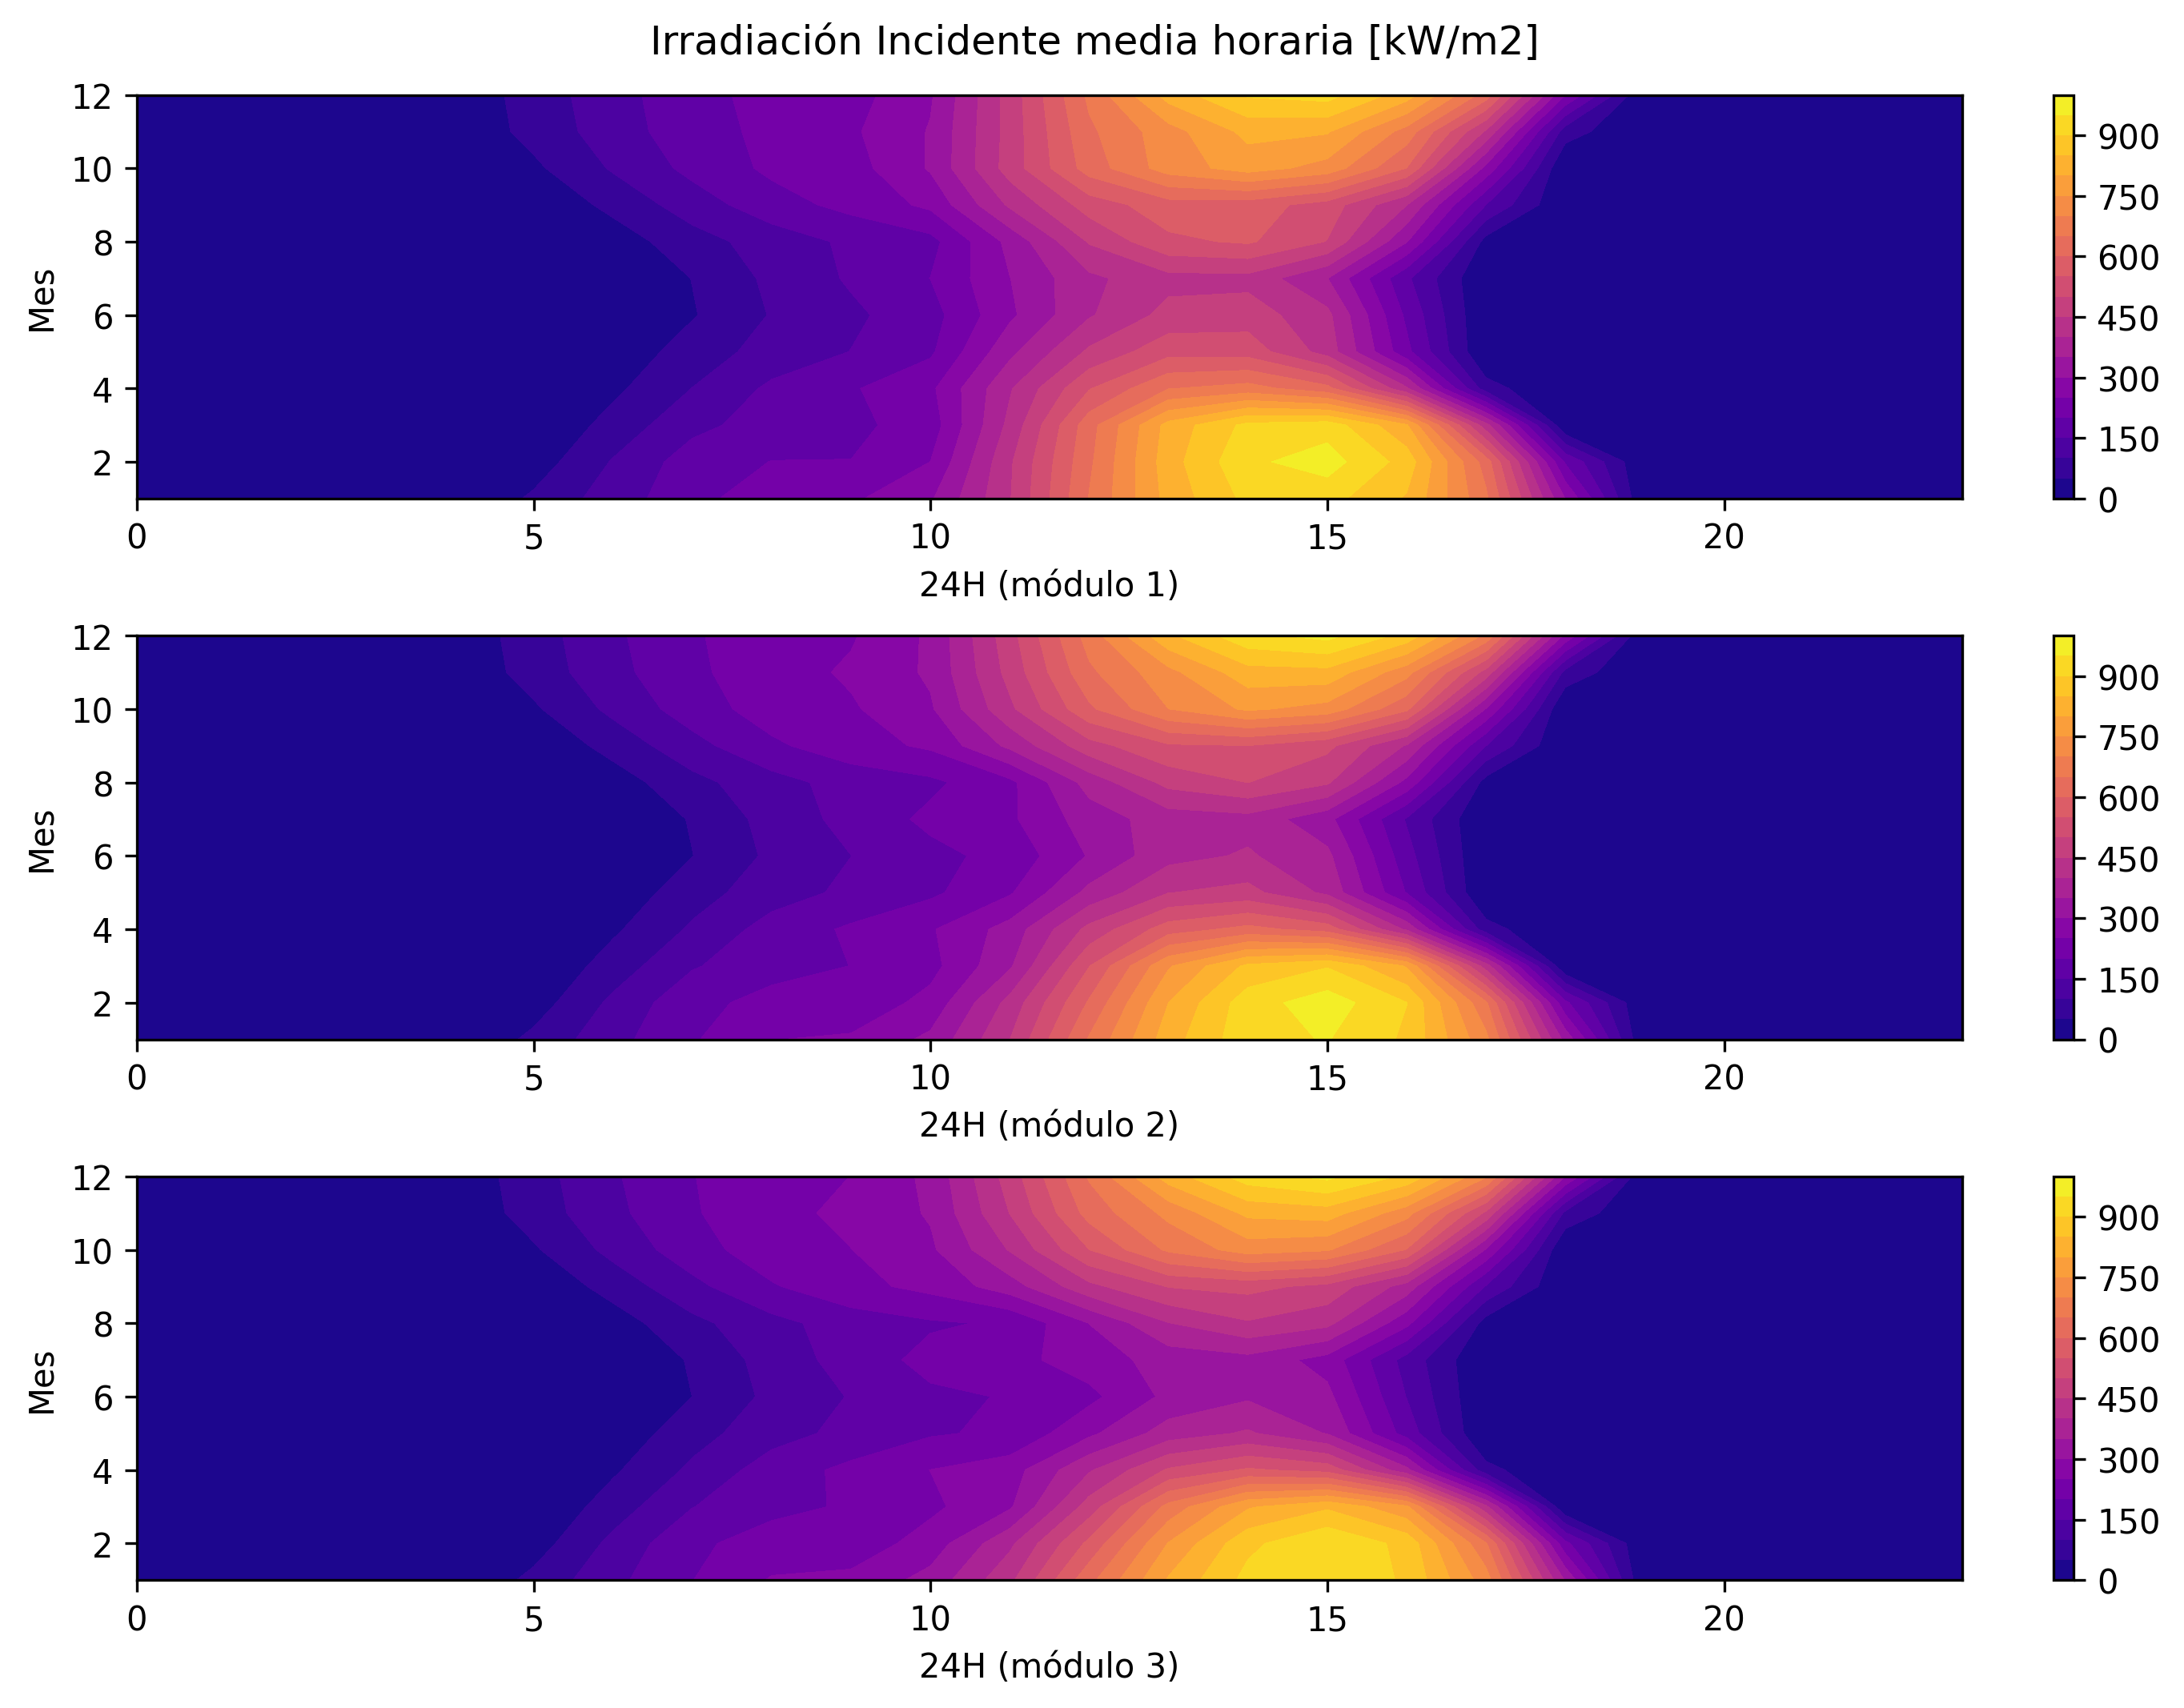

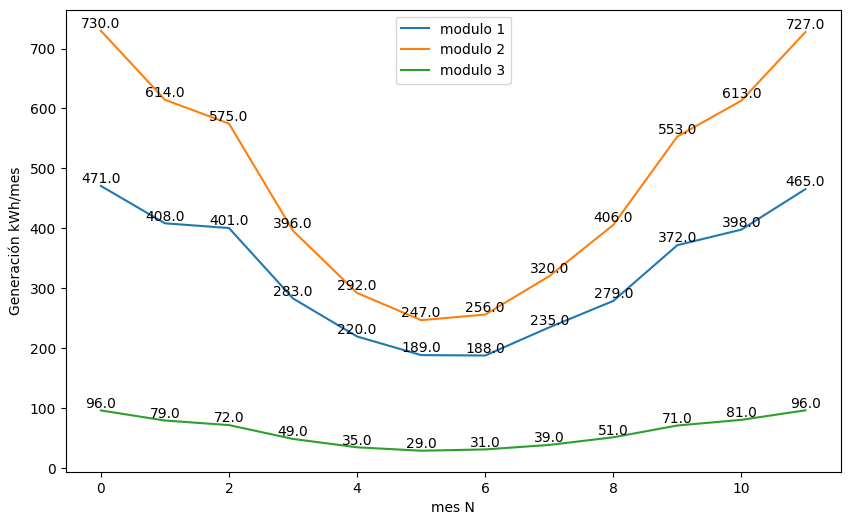

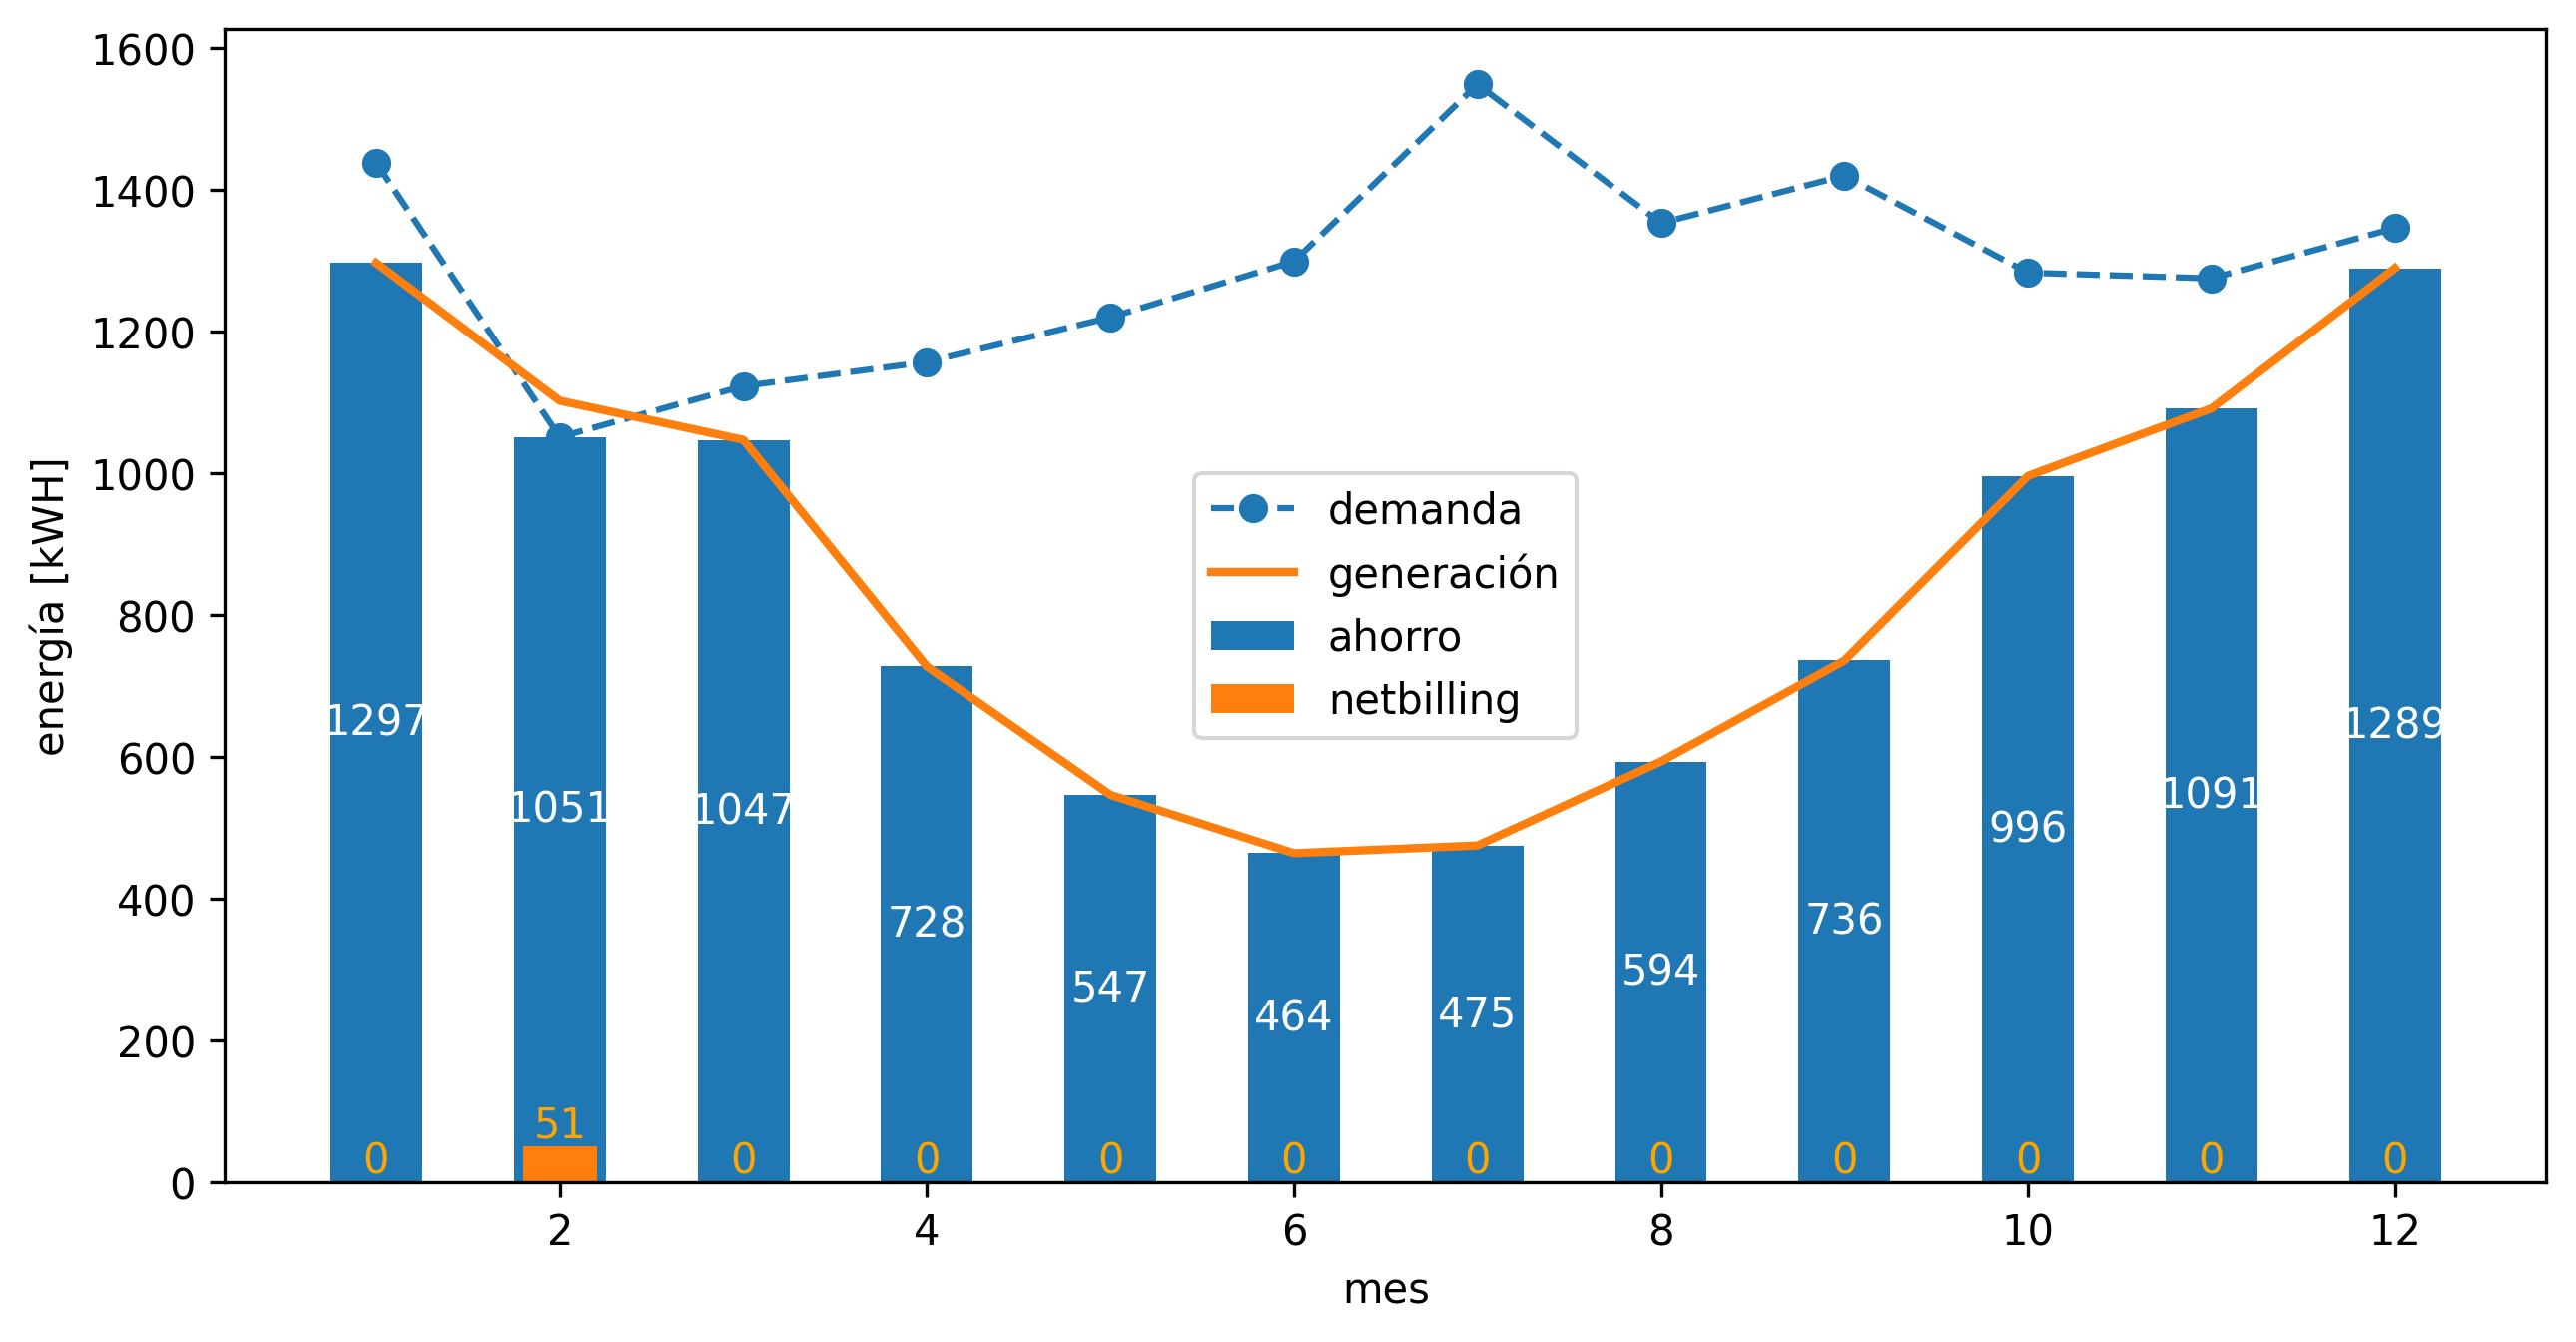

<Figure size 1920x1440 with 0 Axes>

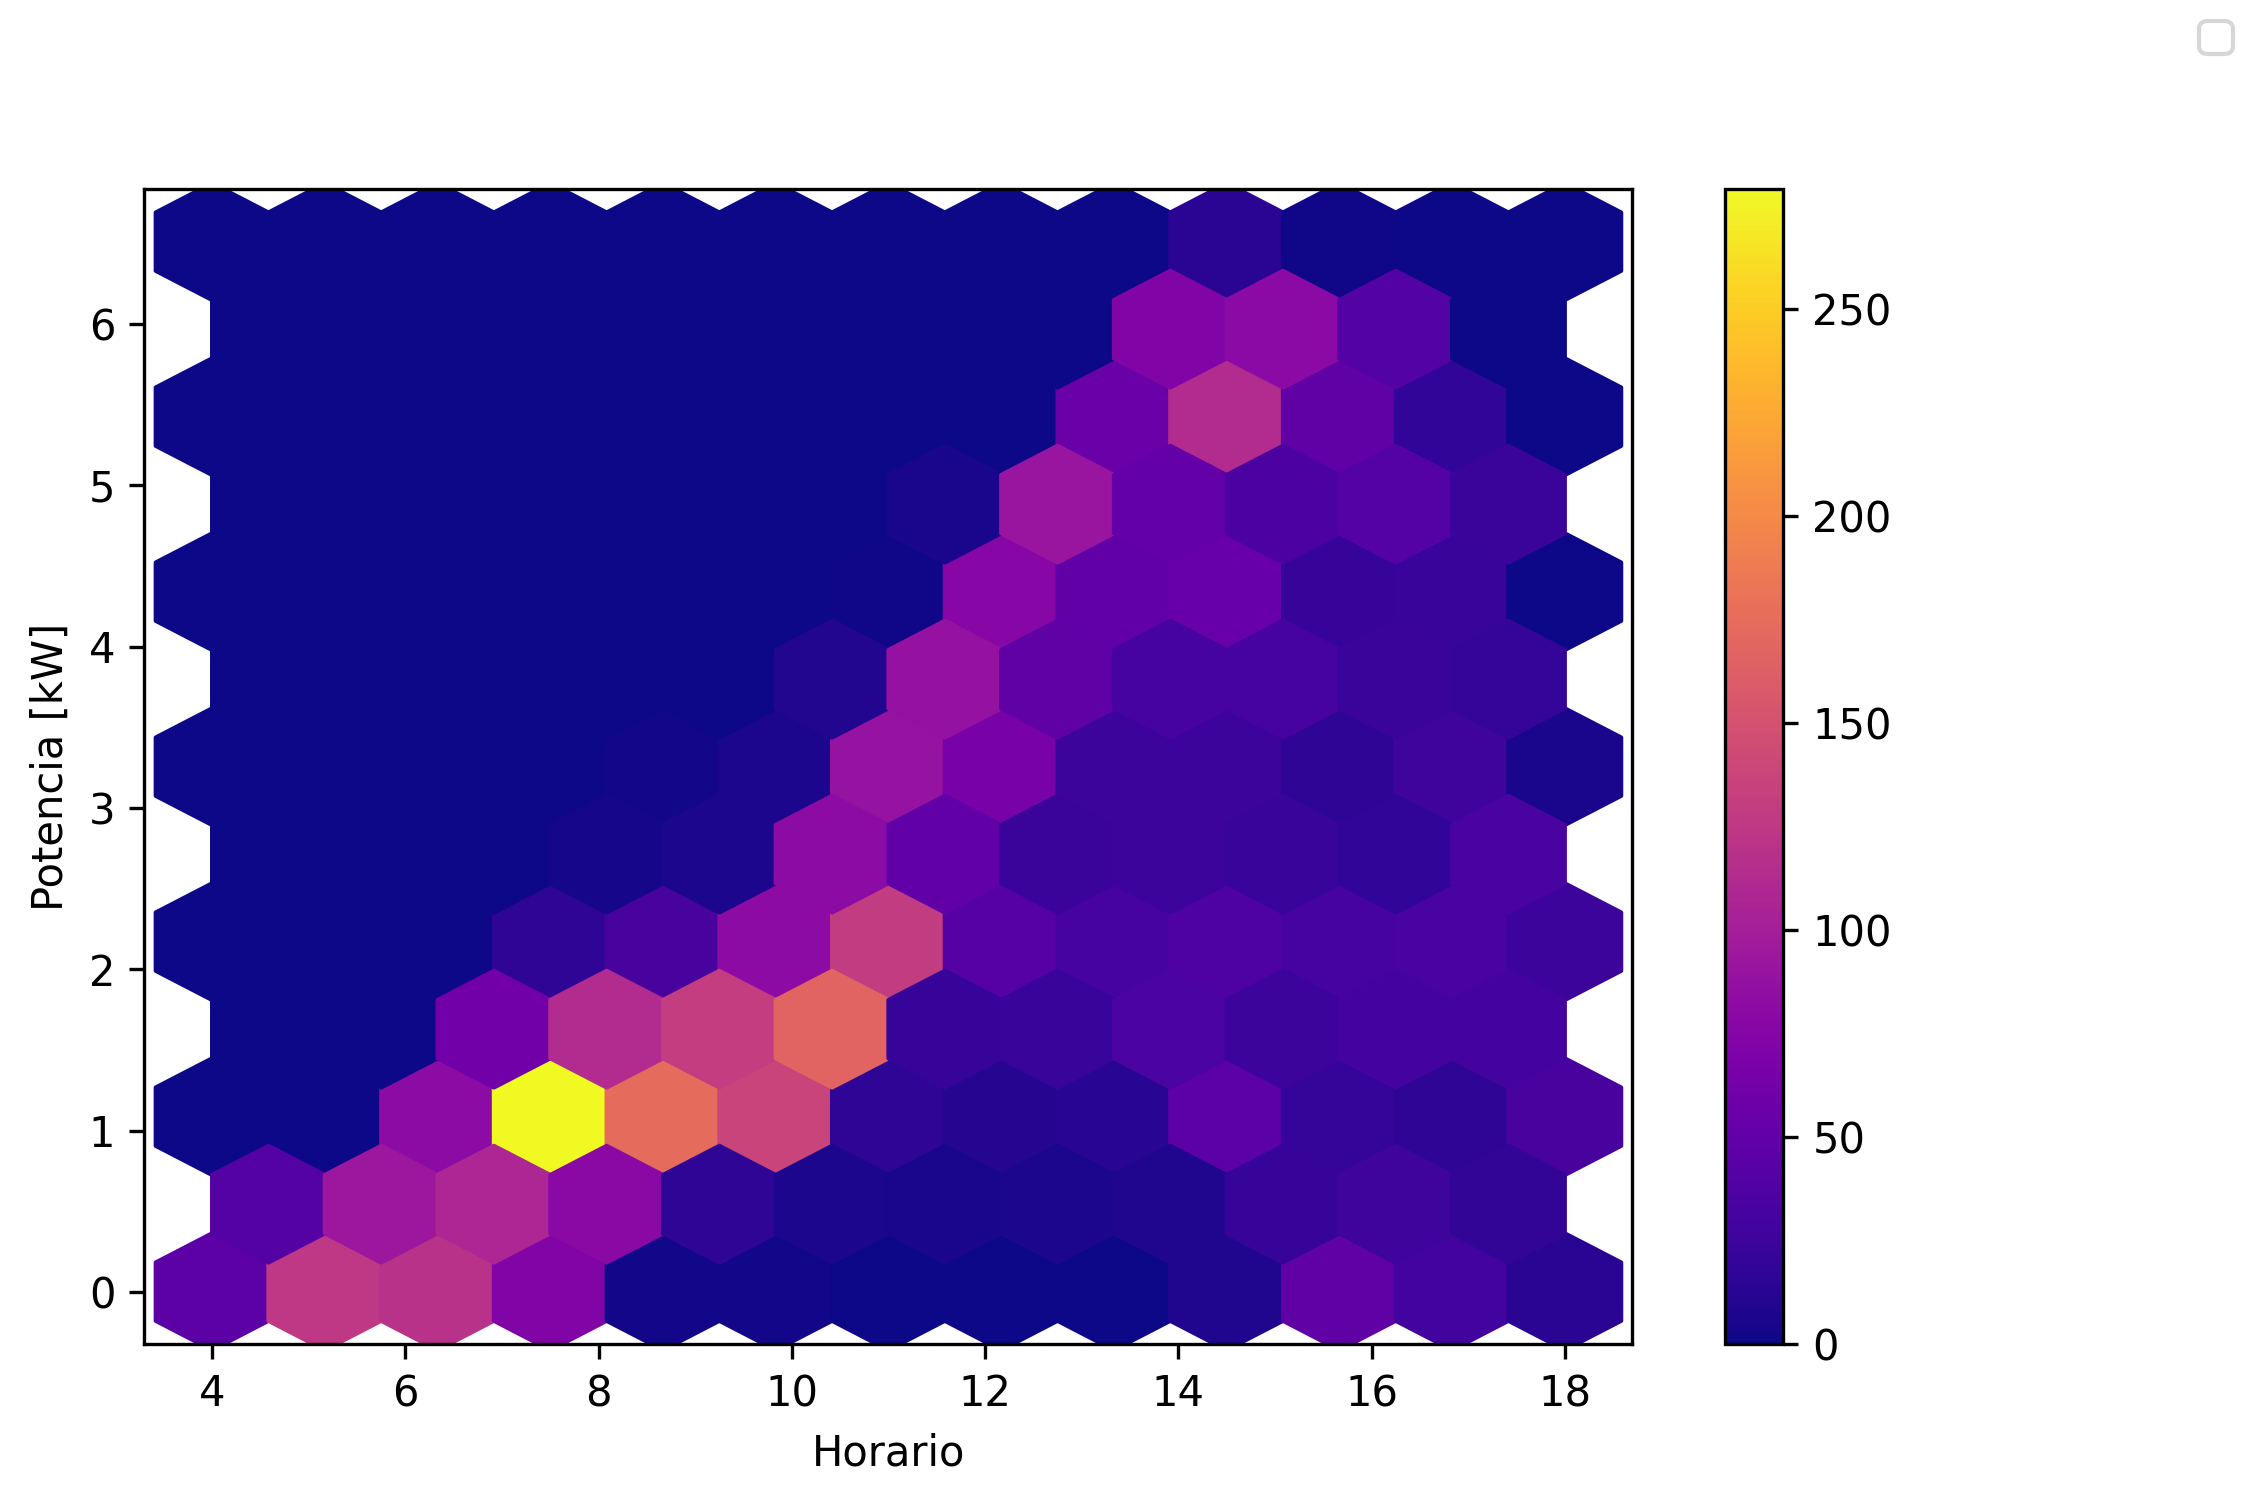

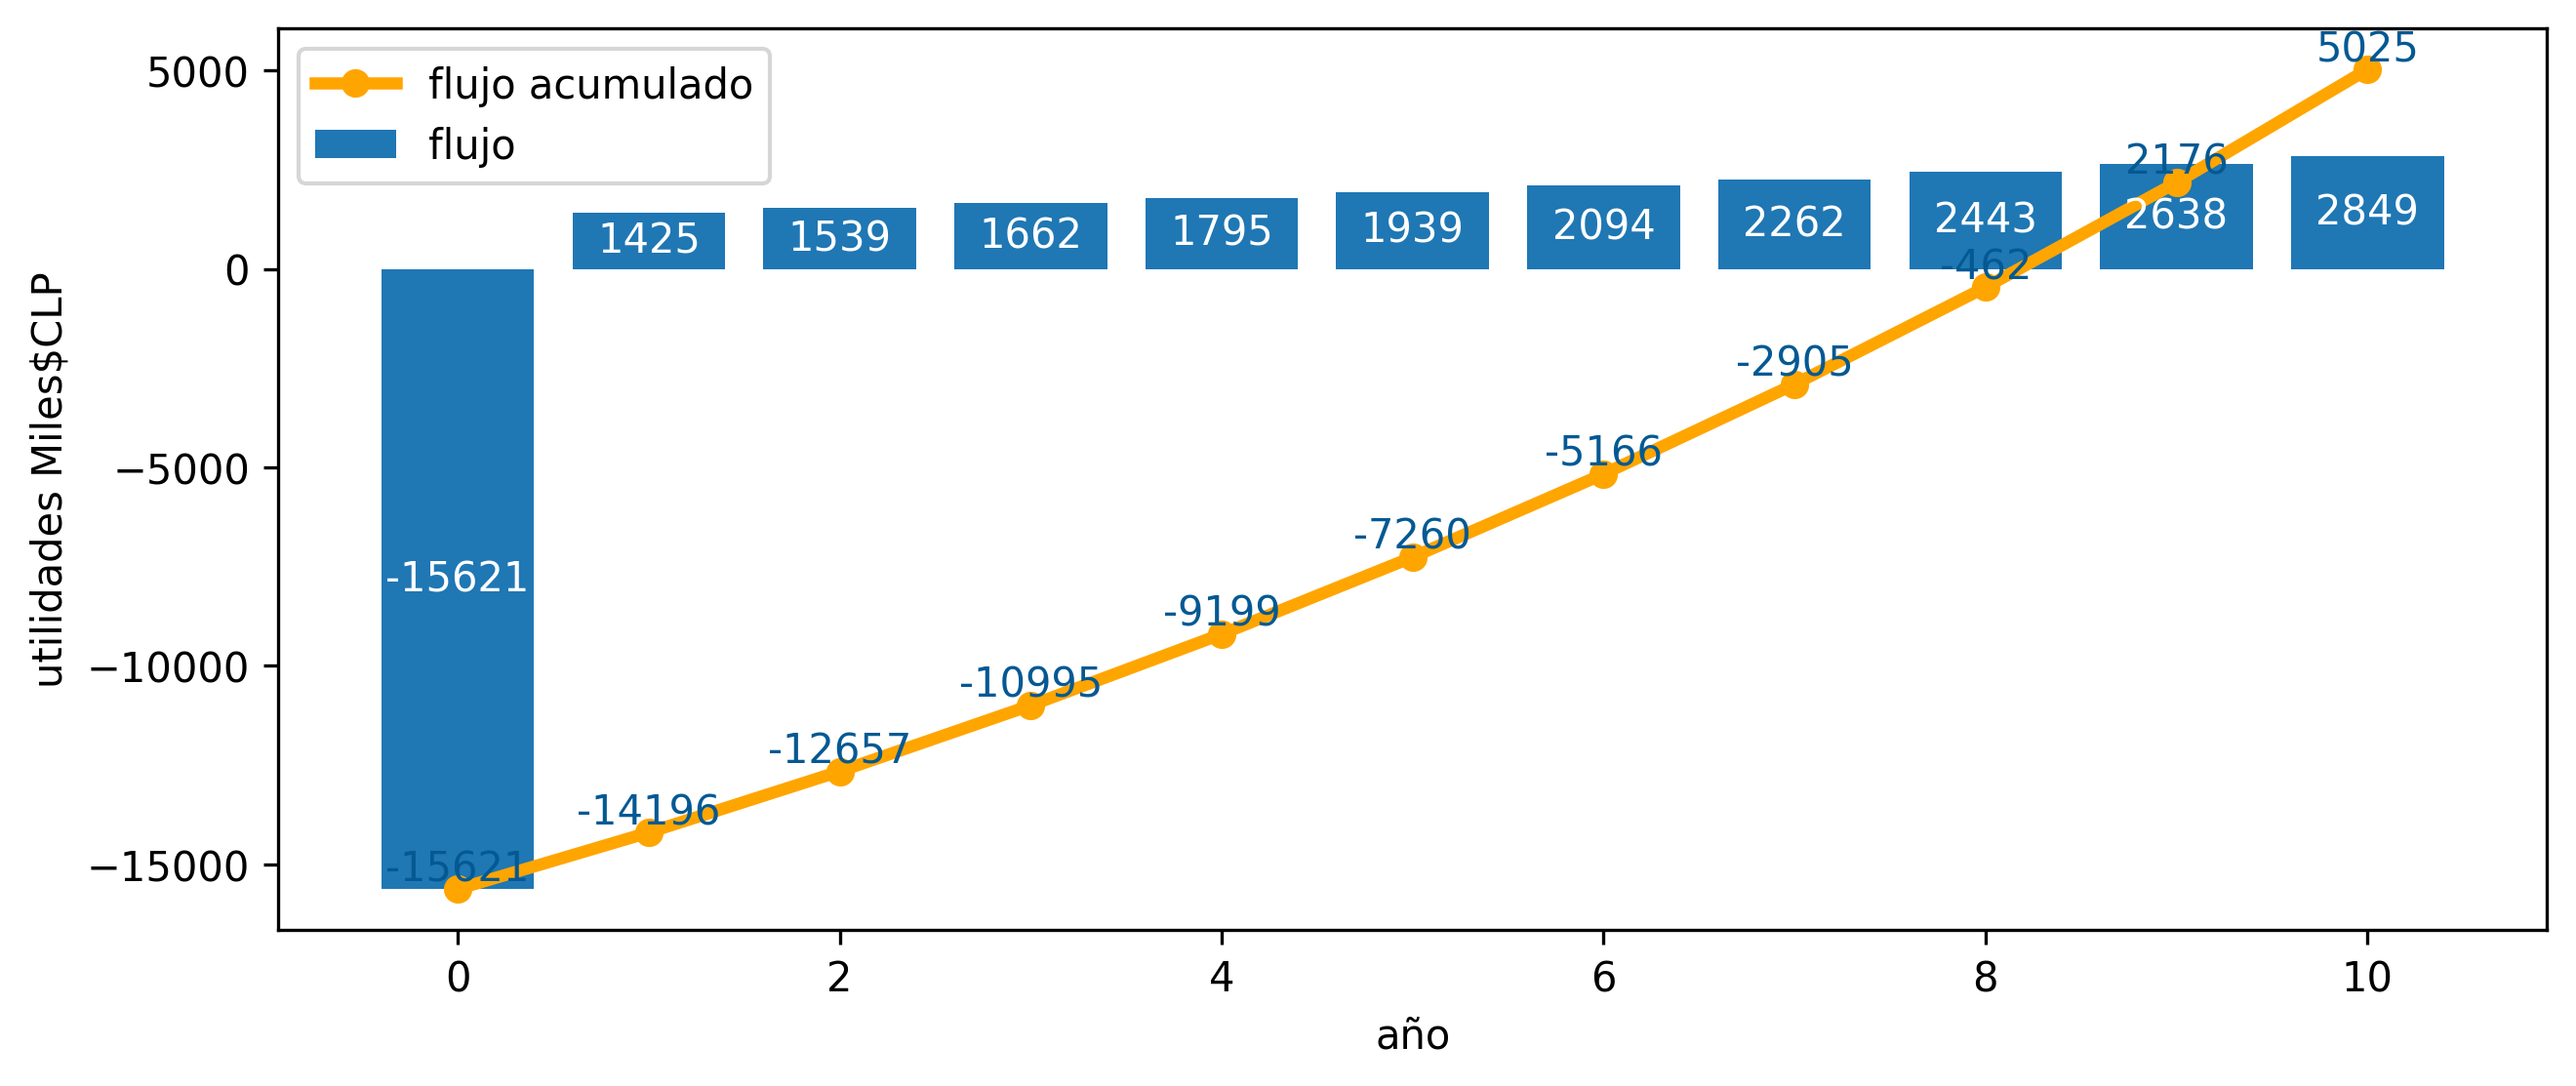

In [11]:
#dep
from models.plotter import plotter
plotter(project,PATH)

In [12]:
#set into doc
plot_list = [
    'plot_consumption_forecast',
    'plot_irradiance',
    'plot_temperature',
    'plot_components',
    'plot_components_irr',
    'plot_components_production',
    'plot_production_performance',
    'plot_performance_frequency',
    'plot_flux',
    'map_location'
]

for plot in plot_list:
    memory_report.replace_pic(plot,PATH+f'{plot}.png')
    print('replaced plot:',plot)

replaced plot: plot_consumption_forecast
replaced plot: plot_irradiance
replaced plot: plot_temperature
replaced plot: plot_components
replaced plot: plot_components_irr
replaced plot: plot_components_production
replaced plot: plot_production_performance
replaced plot: plot_performance_frequency
replaced plot: plot_flux
replaced plot: map_location


In [13]:
from datetime import datetime
memory_report.save(PATH+f"reporte_memoria_calculo.docx")
bidding_report.save(PATH+f"reporte_pliegos_técnicos.docx")
print('work',project,'finish at: ',datetime.now())

work <models.inventory.Project object at 0x00000186829AF380> finish at:  2024-11-21 14:39:56.210328
